In [1]:
# packages

# JAX
import jax.numpy as np
from jax import grad, hessian, vmap
# from jax.config import config; 
# config.update("jax_enable_x64", True)

# numpy
import numpy as onp
from numpy import random

# plot figures
import matplotlib.pyplot as plt

\begin{equation}
\begin{align*}
&\quad \nabla^2 u = 0 \\
\text{s.t.}&\quad g(x=0,y) = g(x=1,y) = g(x,y=0) = 0 \\
 &\quad g(x,y=1) = 100 
\end{align*}
\end{equation}

In [2]:
# dimension of the PDEs
dim = 2

# set parameters
alpha = 1
m = 3

# fix random seeds, for generating reference solution & sampled points
random.seed(10)

# right hand side
def f(x1, x2):
    return 1

# boundary value
def g(x1, x2):
    return 100. * np.logical_or(np.logical_or(x1 == 0.,(x1 == 1.)),
                                (x2 == 0.))
    # return (np.sin(2*np.pi*x1) + np.sin(2*np.pi*x2))

print(g(0,0.5))
print(g(1,0.5))
print(g(0.5,0))
print(g(0.5,1))

100.0
100.0
100.0
0.0


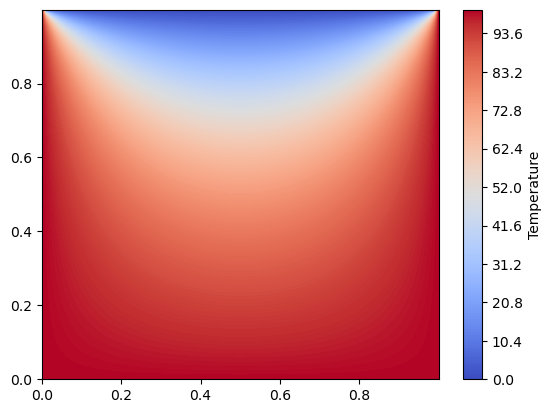

In [7]:
# Numeric solution:
h = 0.0101
length_x = 1.0
length_y = 1.0
x_vals = onp.arange(0, length_x + 0.001, h)
y_vals = onp.arange(0, length_y + 0.001, h)

# The coefficient matrix A is now m*n by m*n, 
# since that is the total number of points.
# The right-hand side vector b is m*n by 1.
A = onp.zeros((len(x_vals)*len(y_vals), len(x_vals)*len(y_vals)))
b = onp.zeros(len(x_vals)*len(y_vals))

u_left = 100
u_right = 100
u_bottom = 100
u_top = 0

for j, y in enumerate(y_vals):
    for i, x in enumerate(x_vals):
        # for convenience, calculate all indices now
        kij = j*len(x_vals) + i
        kim1j = j*len(x_vals) + i - 1
        kip1j = j*len(x_vals) + i + 1
        kijm1 = (j-1)*len(x_vals) + i
        kijp1 = (j+1)*len(x_vals) + i
        if i == 0:
            # this is the left boundary
            A[kij, kij] = 1
            b[kij] = u_left
        elif i == len(x_vals) - 1:
            # right boundary
            A[kij, kij] = 1
            b[kij] = u_right
        elif j == 0:
            # bottom boundary
            A[kij, kij] = 1
            b[kij] = u_bottom
        elif j == len(y_vals) - 1:
            # top boundary
            A[kij, kij] = 1
            b[kij] = u_top
        else:
            # coefficients for interior points, based
            # on the recursion formula
            A[kij, kim1j] = 1
            A[kij, kip1j] = 1
            A[kij, kijm1] = 1
            A[kij, kijp1] = 1
            A[kij, kij] = -4
u = onp.linalg.solve(A, b)

u_square = onp.reshape(u, (len(y_vals), len(x_vals)))
plt.contourf(x_vals, y_vals, u_square, levels=255, cmap=plt.cm.coolwarm)
plt.colorbar(label='Temperature')
plt.show()

In [8]:
u_true = u.reshape(len(y_vals), len(x_vals))
print(u_true.shape)

(100, 100)


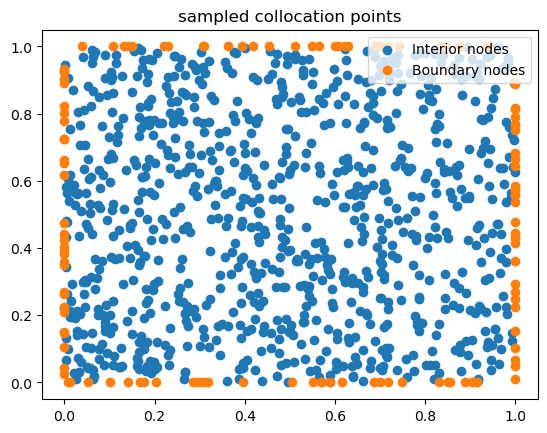

In [9]:
# sampled collocation points

def sample_points(N_domain, N_boundary):
    # interior nodes
    X_domain = random.uniform(0.0, 1.0, (N_domain, 2))
    X_boundary = onp.zeros((N_boundary, 2))

    # generate random boundary points on the faces of the domain 
    edge_size = N_boundary//4

    # bottom face
    X_boundary[:edge_size, 0] = random.uniform(0.0, 1.0, edge_size)
    # right face
    X_boundary[edge_size:2*edge_size, 0] += 1
    X_boundary[edge_size:2*edge_size, 1] = \
        random.uniform(0.0, 1.0, edge_size)
    # top face
    X_boundary[2*edge_size:3*edge_size, 0] = \
        random.uniform(0.01, 0.99, edge_size)
    X_boundary[2*edge_size:3*edge_size, 1] += 1
    # X_boundary[edge_size:, 0] = \
    #     random.uniform(0.0, 1.0, edge_size)
    # X_boundary[edge_size:, 1] += 1
    # left face
    X_boundary[3*edge_size:4*edge_size, 1] = \
        random.uniform(0.0, 1.0, edge_size)
    return X_domain, X_boundary

N_pts =30
N_domain_tot = N_pts**2
N_boundary_tot = 4*(N_pts+1)
X_domain_tot, X_boundary_tot = sample_points(N_domain_tot, N_boundary_tot)

fig, ax = plt.subplots()
ax.scatter(X_domain_tot[range(N_domain_tot), 0], X_domain_tot[range(N_domain_tot), 1], label='Interior nodes')
ax.scatter(X_boundary_tot[range(N_boundary_tot), 0], X_boundary_tot[range(N_boundary_tot), 1], label='Boundary nodes')
ax.legend(loc="upper right")
plt.title('sampled collocation points')
plt.show()

In [ ]:
import jax
import haiku as hk

# create MLP neural network
def mlp_model(x):
    # base network
    k = 30
    act = jax.nn.gelu
    mlp_ = hk.Sequential(
        [hk.Linear(k), act,
         hk.Linear(k), act,
         hk.Linear(1)])
    return mlp_(x)

# Transform the model for JAX/Haiku
mlp_fn = hk.without_apply_rng(hk.transform(mlp_model))
# Initialize the model
mlp_init_params = mlp_fn.init(jax.random.PRNGKey(0), X_domain_tot[:1])
params_ = mlp_init_params

In [ ]:



# Define a real valued kernel kappa(x, y; sigma) \to R
def kappa(x1, x2, y1, y2, sigma):
    # x,y are 2D input row vectors
    x_ = mlp_fn.apply(np.hstack((x1,x2)))
    y_ = mlp_fn.apply(np.hstack((y1,y2)))
    # sigma is the variance parameter
    return np.exp(-(1/(2*sigma**2))*( (x_-y_)**2 ))

# define derivatives of the kernel 
def Delta_x_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += grad(grad(kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val

def Delta_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(kappa, 2), 2)(x1, x2, y1, y2, sigma)
    val += grad(grad(kappa, 3), 3)(x1, x2, y1, y2, sigma)
    return val

def Delta_x_y_kappa(x1, x2, y1, y2, sigma):
    val = grad(grad(Delta_y_kappa, 0), 0)(x1, x2, y1, y2, sigma)
    val += grad(grad(Delta_y_kappa, 1), 1)(x1, x2, y1, y2, sigma)
    return val


In [24]:
# vectorized construction of Theta
def assembly_Theta(X_domain, X_boundary, nugget, set_sigma):
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    Theta = np.zeros((2*N_domain + N_boundary, 2*N_domain + N_boundary))

    # auxiliary variables to make things readable
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]

    Xdb0=np.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=np.concatenate([Xd1, X_boundary[:N_boundary, 1]])

    # interior -- interior 
    XXdd0=np.transpose(np.tile(Xd0,(N_domain,1)))
    XXdd1=np.transpose(np.tile(Xd1,(N_domain,1)))

    # interior+boudary -- interior+bpundary
    XXdbdb0=np.transpose(np.tile(Xdb0,(N_domain+N_boundary,1)))
    XXdbdb1=np.transpose(np.tile(Xdb1,(N_domain+N_boundary,1)))

    # interior v.s. interior+boundary
    XXddb0=np.transpose(np.tile(Xd0,(N_domain+N_boundary,1)))
    XXddb1=np.transpose(np.tile(Xd1,(N_domain+N_boundary,1)))
    XXddb0_2=np.tile(Xdb0,(N_domain,1))
    XXddb1_2=np.tile(Xdb1,(N_domain,1))

    # Construct kernel matrix
    # interior v.s. interior (Laplace)
    val = vmap(lambda x1, x2, y1, y2: Delta_x_y_kappa(x1, x2, y1, y2, set_sigma))(XXdd0.flatten(),XXdd1.flatten(),onp.transpose(XXdd0).flatten(),onp.transpose(XXdd1).flatten())
    Theta = Theta.at[0:N_domain, 0:N_domain].set(val.reshape(N_domain, N_domain))
    
    # interior+boundary v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: kappa(x1, x2, y1, y2, set_sigma))(XXdbdb0.flatten(),XXdbdb1.flatten(),onp.transpose(XXdbdb0).flatten(),onp.transpose(XXdbdb1).flatten())
    Theta = Theta.at[N_domain:, N_domain:].set(val.reshape(N_domain+N_boundary, N_domain+N_boundary))

    # interior v.s. interior+boundary
    val = vmap(lambda x1, x2, y1, y2: Delta_x_kappa(x1, x2, y1, y2, set_sigma))(XXddb0.flatten(),XXddb1.flatten(),XXddb0_2.flatten(),XXddb1_2.flatten())
    Theta = Theta.at[:N_domain, N_domain:].set(val.reshape(N_domain, N_domain+N_boundary))
    Theta = Theta.at[N_domain:, :N_domain].set(onp.transpose(onp.reshape(val, (N_domain, N_domain+N_boundary))))
    
    # calculate trace
    trace1 = np.trace(Theta[:N_domain, :N_domain])
    trace2 = np.trace(Theta[N_domain:, N_domain:])
    ratio = trace1/trace2
    
    temp=np.concatenate((ratio*np.ones((1,N_domain)),np.ones((1,N_domain+N_boundary))), axis=1)
    Theta = Theta + nugget*np.diag(temp[0])
    L = np.linalg.cholesky(Theta)
    
    return L, ratio

# test
set_sigma = 0.2
set_nugget = 1e-4
L, ratio = assembly_Theta(X_domain_tot, X_boundary_tot, set_nugget, set_sigma)
print('trace ratio =', ratio)
print('observation: the trace ratio is large, and our adaptive nugget term is effective')

TypeError: params argument does not appear valid. It should be a mapping but is of type <class 'jax._src.interpreters.ad.JVPTracer'>. For reference the parameters for apply are `apply(params, rng, ...)`` for `hk.transform` and `apply(params, state, rng, ...)` for `hk.transform_with_state`.
The argument was: Traced<ShapedArray(float32[2])>with<JVPTrace(level=5/0)> with
  primal = Traced<ShapedArray(float32[2])>with<JVPTrace(level=3/0)> with
    primal = Traced<ShapedArray(float32[2])>with<BatchTrace(level=1/0)> with
      val = Array([[0.2623659 , 0.23962452],
       [0.2623659 , 0.23962452],
       [0.2623659 , 0.23962452],
       ...,
       [0.7142    , 0.10356852],
       [0.7142    , 0.10356852],
       [0.7142    , 0.10356852]], dtype=float32)
      batch_dim = 0
    tangent = Traced<ShapedArray(float32[2])>with<JaxprTrace(level=2/0)> with
      pval = (ShapedArray(float32[2]), None)
      recipe = JaxprEqnRecipe(eqn_id=<object object at 0x00000225EC6421D0>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace(level=2/0)>, Traced<ConcreteArray([0.], dtype=float32):JaxprTrace(level=2/0)>), out_tracer_refs=[<weakref at 0x00000225F48DB6A0; to 'JaxprTracer' at 0x00000225F48DB5B0>], out_avals=[ShapedArray(float32[2])], primitive=concatenate, params={'dimension': 0}, effects=frozenset(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x00000225F1A0ABA0>, name_stack=NameStack(stack=(Transform(name='jvp'), Transform(name='jvp'), Transform(name='jvp'), Transform(name='jvp')))))
  tangent = Traced<ShapedArray(float32[2])>with<JaxprTrace(level=4/0)> with
    pval = (ShapedArray(float32[2]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x00000225EC6420D0>, in_tracers=(Traced<ShapedArray(float32[1]):JaxprTrace(level=4/0)>, Traced<ConcreteArray([0.], dtype=float32):JaxprTrace(level=4/0)>), out_tracer_refs=[<weakref at 0x00000225F48DB970; to 'JaxprTracer' at 0x00000225F48DB920>], out_avals=[ShapedArray(float32[2])], primitive=concatenate, params={'dimension': 0}, effects=frozenset(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x00000225F1A09C50>, name_stack=NameStack(stack=(Transform(name='jvp'), Transform(name='jvp'), Transform(name='jvp'))))).

iter = 0 J = 9106975.0
iter =  1 Gauss-Newton step size = 1  J =  4312.6494
iter =  2 Gauss-Newton step size = 1  J =  4312.6465
iter =  3 Gauss-Newton step size = 1  J =  4312.6475
iter =  4 Gauss-Newton step size = 1  J =  4312.6465
iter =  5 Gauss-Newton step size = 1  J =  4312.648


Text(0.5, 1.0, 'Loss function history')

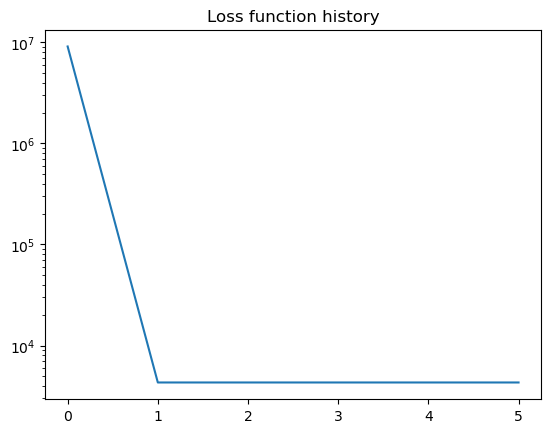

In [526]:
# loss function
def J(z,rhs_f,bdy_g,L):
    zz = np.append(rhs_f, z) 
    ww = np.append(zz, bdy_g)
    ss = np.linalg.solve(L, ww)
    return np.dot(ss, ss)

grad_J=grad(J)

# # linearized loss function: used for GN method
# def GN_J(z,rhs_f,bdy_g,L):
#     n_domain = rhs_f.shape[0]
#     z1 = z[:n_domain]
#     z0 = z[n_domain:]
#     zz = np.append(z1, z0) 
#     # print(zz[0])
#     # zz = np.append(alpha*(z**m) - rhs_f, z) 
#     ww = np.append(zz, bdy_g)
#     ss = np.linalg.solve(L, ww)
#     return np.dot(ss, ss)

Hessian_GN=hessian(J)

def pde_solver(X_domain, X_boundary, nugget, max_iter, step_size, initial_sol, set_sigma):
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])
    bdy_g = vmap(g)(X_boundary[:,0], X_boundary[:,1])
    L, ratio = assembly_Theta(X_domain, X_boundary, nugget, set_sigma)

    sol = initial_sol
    old_sol = initial_sol
    J_hist = [] # history of loss function values
    J_now = J(sol,rhs_f,bdy_g,L)
    J_hist.append(J_now)
    
    print('iter = 0', 'J =', J_now) # print out history
    
    for iter_step in range(1, max_iter+1):
        temp = np.linalg.solve(Hessian_GN(sol,rhs_f,bdy_g,L), grad_J(sol,rhs_f,bdy_g,L))
        old_sol = sol
        sol = sol - step_size*temp
        
        J_now = J(sol,rhs_f,bdy_g,L)
        J_hist.append(J_now)
        # print out history
        print('iter = ', iter_step, 'Gauss-Newton step size =', step_size, ' J = ', J_now)
    return sol, J_hist, L


# err at collocation points
def val_to_idx(u, x):
    n = len(u)
    return np.floor(n * x).astype(np.int32)

initial_sol = random.normal(0.0, 1.0, (N_domain_tot)) # random initial guess
max_iter = 5
step_size = 1
set_sigma = 0.20007454
set_nugget = 1e-4
sol, J_hist, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_iter, step_size, initial_sol, set_sigma)
# sol = sol[X_domain_tot.shape[0]:]

plt.plot(np.arange(max_iter+1),J_hist)
plt.yscale("log")
plt.title('Loss function history')

iter = 0 J = 8506502.0
iter =  1 Gauss-Newton step size = 1  J =  395.75735
iter =  2 Gauss-Newton step size = 1  J =  395.75705
iter =  3 Gauss-Newton step size = 1  J =  395.75754
this loss: 5625.38330078125
iter = 0 J = 7871811.5
iter =  1 Gauss-Newton step size = 1  J =  423.4206
iter =  2 Gauss-Newton step size = 1  J =  423.42065
iter =  3 Gauss-Newton step size = 1  J =  423.42062
this loss: 5624.11181640625
iter = 0 J = 8534207.0
iter =  1 Gauss-Newton step size = 1  J =  449.23065
iter =  2 Gauss-Newton step size = 1  J =  449.23087
iter =  3 Gauss-Newton step size = 1  J =  449.2303
this loss: 5623.5849609375
iter = 0 J = 7880205.5
iter =  1 Gauss-Newton step size = 1  J =  470.88657
iter =  2 Gauss-Newton step size = 1  J =  470.8867
iter =  3 Gauss-Newton step size = 1  J =  470.88617
this loss: 5623.9794921875
iter = 0 J = 8124165.0
iter =  1 Gauss-Newton step size = 1  J =  484.4092
iter =  2 Gauss-Newton step size = 1  J =  484.40936
iter =  3 Gauss-Newton step size = 1 

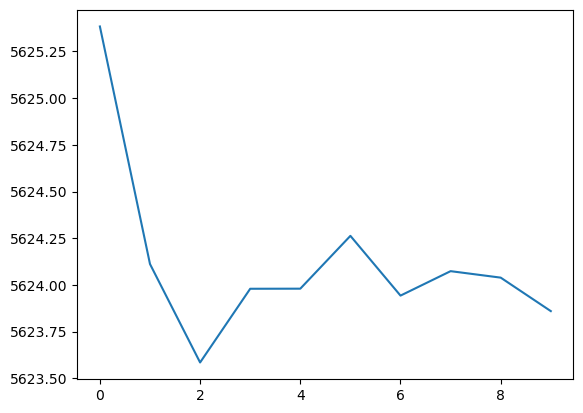

In [519]:
from jax import value_and_grad
from jax.example_libraries.optimizers import adam

def overall_loss(sigma, z_sol, rhs_f, bdy_g, X_domain, X_boundary, nugget):
    zz = np.append(rhs_f, z_sol) 
    ww = np.append(zz, bdy_g)
    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])
    bdy_g = vmap(g)(X_boundary[:,0], X_boundary[:,1])
    L, ratio = assembly_Theta(X_domain, X_boundary, nugget, sigma)
    ss = np.linalg.solve(L, ww)
    return np.dot(ss, ss) - np.log(np.log(np.exp(sigma))) * (2*X_domain.shape[0] + X_boundary.shape[0])


epochs = 10
initial_sigma = 0.066
rhs_f = vmap(f)(X_domain_tot[:,0], X_domain_tot[:,1])
bdy_g = vmap(g)(X_boundary_tot[:,0], X_boundary_tot[:,1])

lr = 1e-3
opt_init, opt_update, get_params = adam(lr)
opt_state = opt_init(initial_sigma)
loss_history = []
for e in range(epochs):
    initial_sol = random.normal(0.0, 1.0, (N_domain_tot)) # random initial guess
    max_pde_iter = 3
    step_size = 1
    set_nugget = 1e-4
    sigma_ = get_params(opt_state)
    sol, J_hist, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_pde_iter, step_size, initial_sol, sigma_)
    loss, grads = value_and_grad(overall_loss, 0)(sigma_, sol, rhs_f, bdy_g, X_domain_tot, X_boundary_tot, set_nugget)
    print(f"this loss: {loss}")
    opt_state = opt_update(e, grads, opt_state)
    loss_history.append(loss)

sol, _, L = pde_solver(X_domain_tot, X_boundary_tot, set_nugget, max_pde_iter, step_size, initial_sol, sigma_)
plt.plot(loss_history)

In [520]:
print(get_params(opt_state))
set_sigma = sigma_

0.06818945


In [527]:
sol_truth = u_true[val_to_idx(u_true, X_domain_tot[:,0]),
                   val_to_idx(u_true, X_domain_tot[:,1])]
err_pts = abs(sol_truth-sol)

max_err_pts = np.max(err_pts)

L2_err_pts = np.sqrt(np.sum(err_pts**2) / (N_domain_tot))

print('At collocation points, L2 err= ', L2_err_pts, ' max err=', max_err_pts)

At collocation points, L2 err=  0.41349673  max err= 1.0258392


In [528]:
# use kernel interpolation to extend the solution at test points

def construct_inpTheta(X_test, X_domain, X_boundary):
    N_test = X_test.shape[0]
    N_domain = X_domain.shape[0]
    N_boundary = X_boundary.shape[0]
    inpTheta = onp.zeros((N_test, 2*N_domain + N_boundary))

    # auxiliary variables to make things readable
    
    # X_test coordinates
    Xt0=X_test[:,0]
    Xt1=X_test[:,1]
    
    # interior points coordinates
    Xd0=X_domain[:N_domain, 0]
    Xd1=X_domain[:N_domain, 1]
    
    # interior + boundary points coordinates
    Xdb0=np.concatenate([Xd0, X_boundary[:N_boundary, 0]])
    Xdb1=np.concatenate([Xd1, X_boundary[:N_boundary, 1]])
    
    # test v.s. interior
    XXtd0=np.transpose(np.tile(Xt0,(N_domain,1)))
    XXtd1=np.transpose(np.tile(Xt1,(N_domain,1)))
    XXtd0_2=np.tile(Xd0,(N_test,1))
    XXtd1_2=np.tile(Xd1,(N_test,1))
    
    # test v.s. interior + boundary
    XXtdb0=np.transpose(np.tile(Xt0,(N_domain+N_boundary,1)))
    XXtdb1=np.transpose(np.tile(Xt1,(N_domain+N_boundary,1)))
    XXtdb0_2=np.tile(Xdb0,(N_test,1))
    XXtdb1_2=np.tile(Xdb1,(N_test,1))
    
    # constructing Theta matrix
    val = vmap(lambda x1,x2,y1,y2: Delta_y_kappa(x1, x2, y1, y2, set_sigma))(XXtd0.flatten(),XXtd1.flatten(),XXtd0_2.flatten(),XXtd1_2.flatten())
    inpTheta[:,:N_domain] = onp.reshape(val, (N_test, N_domain))
    
    val = vmap(lambda x1,x2,y1,y2: kappa(x1, x2, y1, y2, set_sigma))(XXtdb0.flatten(),XXtdb1.flatten(),XXtdb0_2.flatten(),XXtdb1_2.flatten())
    inpTheta[:, N_domain:] = onp.reshape(val, (N_test, N_domain+N_boundary))

    XXtt0 = np.transpose(np.tile(Xt0, (N_test,1)))
    XXtt1 = np.transpose(np.tile(Xt1, (N_test,1)))
    inpTheta_star = vmap(lambda x1,x2,y1,y2: kappa(x1,x2,y1,y2,set_sigma))(XXtt0.flatten(),XXtt1.flatten(),XXtt0.flatten(),XXtt1.flatten())

    return inpTheta, inpTheta_star.reshape(N_test, N_test)



def extend_solution(X_test, X_domain, X_boundary, L, v):
        
    inp_Theta, inpTheta_star = construct_inpTheta(X_test, X_domain, X_boundary)
    
    aux = np.linalg.solve(np.transpose(L),np.linalg.solve(L,v))
    
    extended_u = np.matmul(inp_Theta,aux)
    # return extended_u
    aux2 = np.linalg.solve(np.transpose(L),np.linalg.solve(L,np.transpose(inp_Theta)))
    covar_u = inpTheta_star - np.matmul(inp_Theta, aux2)
    return extended_u, covar_u

def sol_and_err_extended(num_pts, X_domain, X_boundary, L, sol, u_true):
    # num_pts is the number of test points in each dimension
    xx= np.linspace(0, 1, num_pts)
    yy = np.linspace(0, 1, num_pts)
    XX, YY = np.meshgrid(xx, yy)

    # vectorized (x,y) coordinates
    XXv = np.array(XX.flatten())
    YYv = np.array(YY.flatten())
    XXv = np.expand_dims(XXv, axis=1) 
    YYv = np.expand_dims(YYv, axis=1) 

    X_test = np.concatenate((XXv,YYv), axis=1)

    rhs_f = vmap(f)(X_domain[:,0], X_domain[:,1])
    bdy_g = vmap(g)(X_boundary[:,0], X_boundary[:,1])
    v = np.append(alpha*(sol**m) - rhs_f, sol) 
    v = np.append(v, bdy_g)

    # extend the solution to test points
    extended_u, covar_u = extend_solution(X_test, X_domain_tot, X_boundary_tot, L, v)
    extended_u = extended_u.reshape(num_pts,num_pts)
    
    # err
    mtx_err = abs(extended_u-u_true)
    
    # L2err
    L2err = np.linalg.norm(extended_u-u_true,'fro')/(num_pts)
    
    # Maxerr
    Maxerr = np.max(abs(extended_u-u_true))
    
    return XX, YY, extended_u, mtx_err, L2err, Maxerr, covar_u

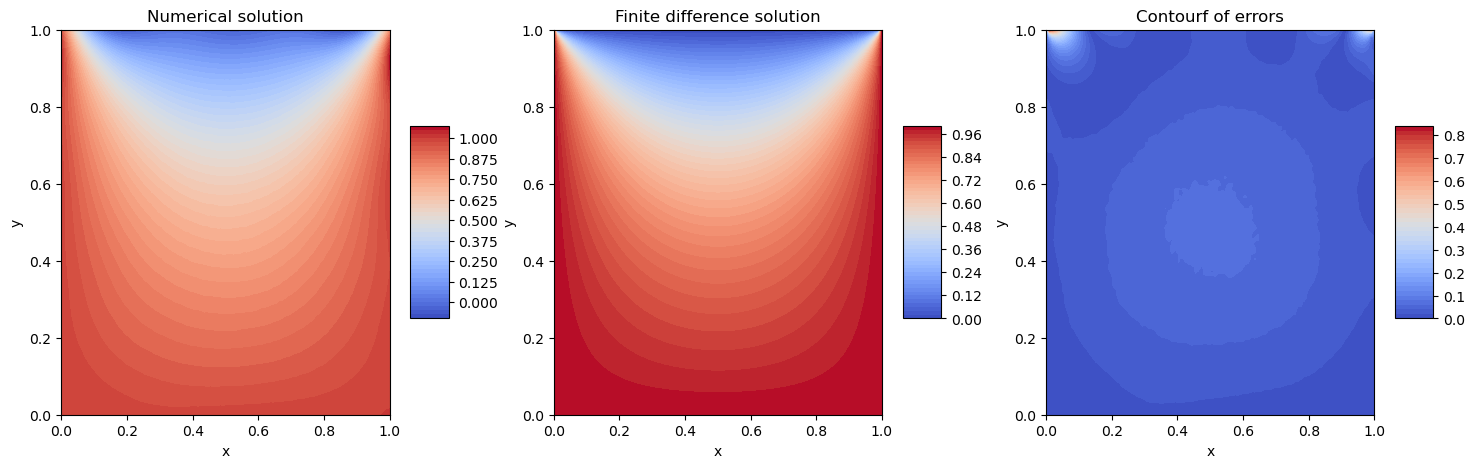

(100, 100)
(100, 100)


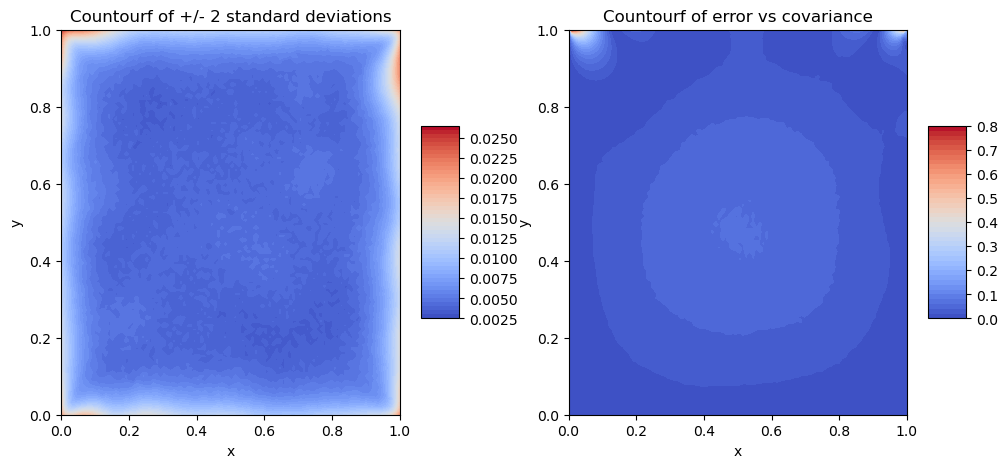

sigma = 0.20007454 , nugget = 0.0001 , # pts:  1024 , L2 error:  0.044105053 , max err:  0.82084656


In [529]:
# plot the extended solution in the whole domain, and calculate the errors
num_pts=100
XX, YY, extended_u, mtx_err, L2err, Maxerr, covar_u = sol_and_err_extended(num_pts, X_domain_tot, X_boundary_tot, L, sol, u_true)

fig = plt.figure(figsize=(18,5))

# plot the numerical solution
ax = fig.add_subplot(131)
u_sol_surf=ax.contourf(XX, YY, extended_u, levels=50, cmap=plt.cm.coolwarm)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Numerical solution')
fig.colorbar(u_sol_surf, shrink= 0.5, aspect = 5)
    
# plot the true solution
ax = fig.add_subplot(132)
u_truth_surf=ax.contourf(XX, YY, u_true, levels=50, cmap=plt.cm.coolwarm)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Finite difference solution')
fig.colorbar(u_truth_surf, shrink= 0.5, aspect = 5)

# contourf
ax = fig.add_subplot(133)
u_contourf=ax.contourf(XX, YY, mtx_err, levels=50, cmap=plt.cm.coolwarm)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Contourf of errors')
fig.colorbar(u_contourf, shrink= 0.5, aspect = 5)

plt.show()

fig = plt.figure(figsize=(12,5))

ax = fig.add_subplot(121)
covar_u_x = 4 * np.sqrt(np.diag(covar_u)).reshape(num_pts, num_pts)
u_sol_cov = ax.contourf(XX, YY, covar_u_x, levels=50, cmap=plt.cm.coolwarm)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Countourf of +/- 2 standard deviations')
fig.colorbar(u_sol_cov, shrink=0.5, aspect=5)


print(covar_u_x.shape)
print(mtx_err.shape)
# errors vs uncertainty:
ax = fig.add_subplot(122)
# Only show wherever error is more than the covariance value
err_vs_covar = np.abs(covar_u_x - mtx_err) * (covar_u_x < mtx_err)
err_vs_covar_fig = ax.contourf(XX, YY, err_vs_covar, levels=50, cmap=plt.cm.coolwarm)
plt.xlabel('x'); plt.ylabel('y'); plt.title('Countourf of error vs covariance')
fig.colorbar(err_vs_covar_fig, shrink=0.5, aspect=5)

plt.show()

# calculate the L2 error
print('sigma =', set_sigma, ', nugget =', set_nugget, ', # pts: ', N_domain_tot+N_boundary_tot, ', L2 error: ', L2err, ', max err: ', Maxerr)